## Importing required libraries


In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import cv2

In [2]:
dataset_path = 'yalefaces/'
train_path= 'train/'
test_path= 'test/'
dataset_dir  = os.listdir(dataset_path)
train_dir=os.listdir(train_path)
test_dir=os.listdir(test_path)
width  = 320
height = 243

## Getting train and test images

Here, we also preprocess the data to from 243x320 to 55x55 to increase the speed of computation

Train Images:


c:\users\san19\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


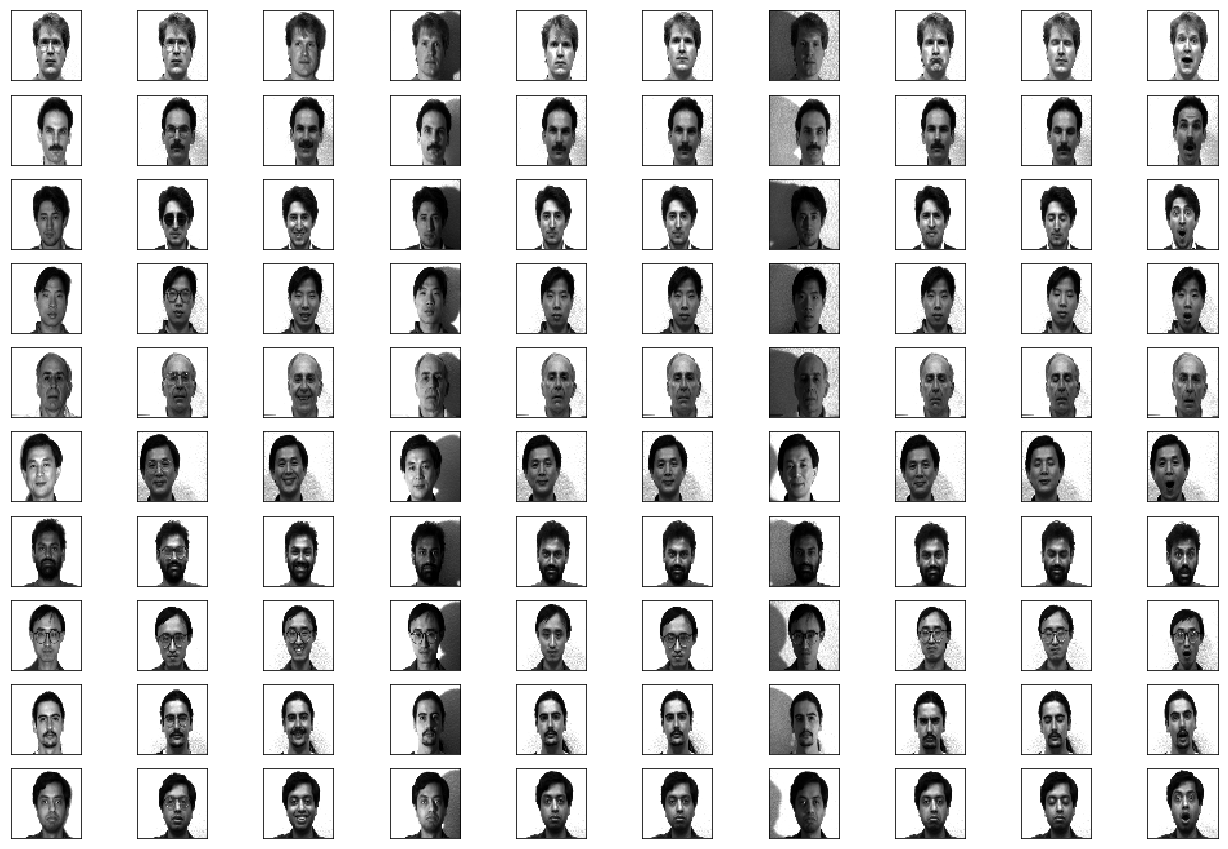

Test Images:


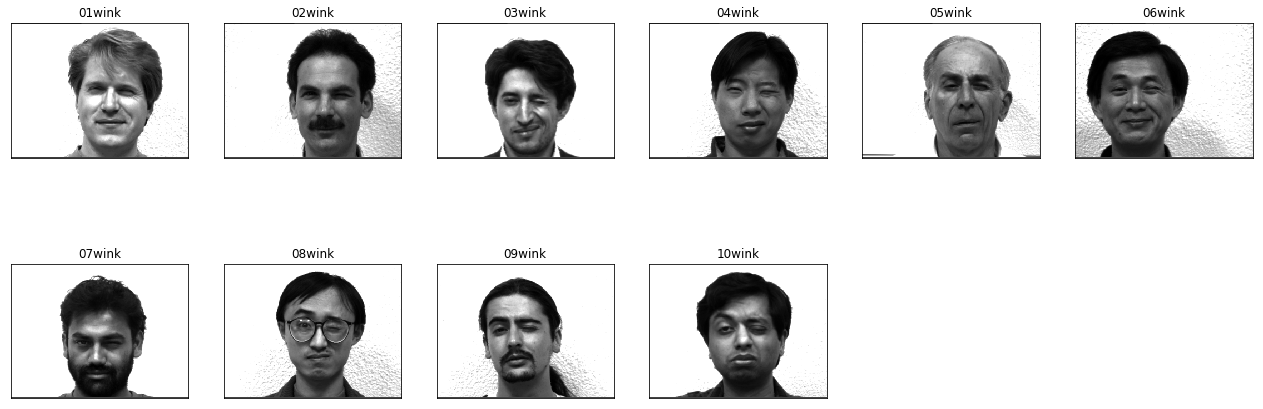

In [3]:
print('Train Images:')
train_image_names = train_dir
training_tensor   = np.ndarray(shape=(len(train_image_names), 55*55), dtype=np.float64)
lst=[]
lstnoresize=[]
for i in range(len(train_image_names)):
    img = plt.imread(train_path + train_image_names[i])
    imresize=cv2.resize(img,(55,55)) #Pre processing
    training_tensor[i,:] = np.array(imresize, dtype='float64').flatten()
    lst.append(imresize)
    plt.subplot(10,10,1+i)
    plt.imshow(imresize, cmap='gray')
    plt.subplots_adjust(right=3.0, top=3)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()
images=np.array(lst)
print('Test Images:')
test_image_names = test_dir
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(test_path + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(6,6,1+i)
    plt.title(test_image_names[i].split('.')[0][-2:]+test_image_names[i].split('.')[1])
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=3.0, top=5)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Finding the mean face

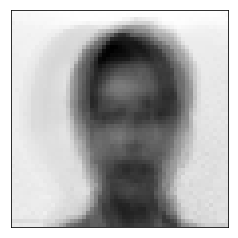

3025

In [4]:
mean_face = np.zeros((1,55*55))
for i in training_tensor:
    mean_face = np.add(mean_face,i)
mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()
plt.imshow(mean_face.reshape(55, 55), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()
len(mean_face)

## Finding principal components, Eigenvectors and Eigenvalues

In [5]:
img_vectors=np.reshape(images,(images.shape[0],images.shape[1]*images.shape[2])) #flattening each image in the array to 1*3025
shortmean=np.mean(img_vectors,axis=0)
image_std_vec=np.std(img_vectors,axis=0)
normalized=[]
for j in img_vectors:
    normalized.append((j-shortmean)/image_std_vec) #normalizing each image by subtracting mean face and dividing by standard deviation
normalized=np.array(normalized)
covar=np.cov(np.transpose(normalized)) #finding the covariance matrix
print(mean_face.shape)
print("Computing Eigen vectors")
eigvals, eigvects=np.linalg.eig(covar) #finding eigenvalues and eigenvectors of covariance matrix
print("Eigen vectors calculated")
eig_vectors=np.real(np.transpose(eigvects))
mean_face=np.reshape(shortmean,(images.shape[1]*images.shape[2]))
print(covar.shape)

(3025,)
Computing Eigen vectors
Eigen vectors calculated
(3025, 3025)


## Top 10 Eigenfaces

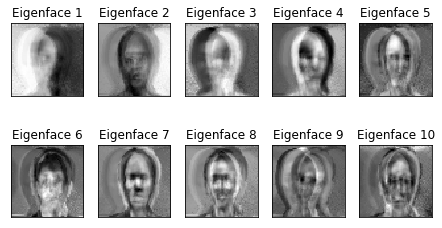

(3025, 3025)


In [6]:
for i in range(10):
    img = eig_vectors[i].reshape(images.shape[1],images.shape[2])
    plt.subplot(2,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.title("Eigenface "+str(i+1))
    plt.subplots_adjust(right=1.1, top=0.9)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    
plt.show()
print(eig_vectors.shape)
imp_eig_vectors=eig_vectors[3:63] #taking only first 10 eigenvectors

## Reading an unknown face

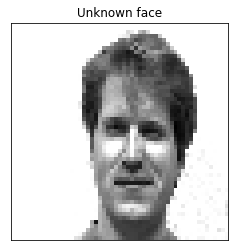

In [7]:
#image reconstruction
unknown_face        = plt.imread('yalefaces/subject01.wink.jpg')
unknown_face_resize=cv2.resize(unknown_face,(55,55))
unknown_face_vector = np.array(unknown_face_resize, dtype='float64').flatten()
plt.imshow(unknown_face_resize, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Finding the image classified to


In [8]:
#first we need the weights for each training image. We project the normalized vector to imp_eig_vectors
w = np.array([np.dot(imp_eig_vectors,i) for i in normalized]) #dont use normalized
print(w[0].shape)

(60,)


8


Text(0.5, 1.0, 'Recognized Person')

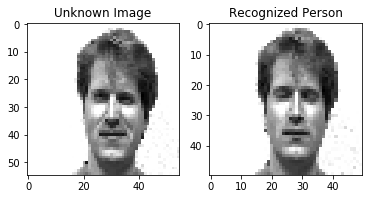

In [9]:

normalized_u_vector=np.subtract(unknown_face_vector,mean_face) #normalize unknown face by subtracting mean
uk_wt=np.dot(imp_eig_vectors,normalized_u_vector) #get weights of normalized vector
diff=w-uk_wt #find the difference
norms=np.linalg.norm(diff,axis=1) #calculate the norm for each training image for the given test image
index=np.argmin(norms) #find the index of the minimum norm (Distance)
print(index) 
plt.subplot(1,2,1)
plt.imshow(unknown_face_resize,cmap='gray')
plt.title('Unknown Image')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(imread('train/'+train_image_names[index]),(50,50)), cmap='gray')
plt.title('Recognized Person')

In [10]:
d={'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[],'10':[]} #taking only 10 subjects for classification of train data
k=1 
while(k<16):
    for i in train_dir:
        if(k<=9):
            q='0'+str(k)
            if(i[7:9]==q):
                d[str(k)].append(i)
        
        else:
            q=k
            if(i[7:9]==str(q)):
                d[str(k)].append(i)
    k+=1
d

{'1': ['subject01.centerlight.jpg',
  'subject01.glasses.gif',
  'subject01.happy.gif',
  'subject01.leftlight.jpg',
  'subject01.noglasses.jpg',
  'subject01.normal.jpg',
  'subject01.rightlight.jpg',
  'subject01.sad.jpg',
  'subject01.sleepy.jpg',
  'subject01.surprised.jpg'],
 '2': ['subject02.centerlight.jpg',
  'subject02.glasses.jpg',
  'subject02.happy.jpg',
  'subject02.leftlight.jpg',
  'subject02.noglasses.jpg',
  'subject02.normal.jpg',
  'subject02.rightlight.jpg',
  'subject02.sad.jpg',
  'subject02.sleepy.jpg',
  'subject02.surprised.jpg'],
 '3': ['subject03.centerlight.jpg',
  'subject03.glasses.jpg',
  'subject03.happy.jpg',
  'subject03.leftlight.jpg',
  'subject03.noglasses.jpg',
  'subject03.normal.jpg',
  'subject03.rightlight.jpg',
  'subject03.sad.jpg',
  'subject03.sleepy.jpg',
  'subject03.surprised.jpg'],
 '4': ['subject04.centerlight.jpg',
  'subject04.glasses.jpg',
  'subject04.happy.jpg',
  'subject04.leftlight.jpg',
  'subject04.noglasses.jpg',
  'subject0

In [11]:
#Creating a vector containing samples from each class. This is X vector
X=[d[i] for i in d.keys()]
tensor=[]
for i in range(0,10):
    for j in range(0,10):
        img = plt.imread(train_path + X[i][j])
        imresize=cv2.resize(img,(55,55)).flatten() #Pre processing
        tensor.append(np.array(imresize, dtype='float64')) #getting flattened data for each image for convenience while calculation
#slice the tensor for each class
classes_data=[]
for i in range(0,91,10):
    classes_data.append(tensor[i:i+10]) #classes data is of length 10(for each class) and each item is a numpy array consisting of data for each image in that class, flatttened
classes_data_np=np.array(classes_data) #numpy array of classes_data. Classes_data_np[i] will corresponds to all image data in a particular class
print((classes_data_np[0][0].shape))
print(len(classes_data_np)) #10 classes in total

classes_data_np.shape

(3025,)
10


(10, 10, 3025)

## Now find the weights for each image in class corresponding to number of important principal components (10 in the case)

In [12]:
weights=[] #Corresponds to the weights of images in each class
print(imp_eig_vectors.shape)
for i in range(0,10):
    class_weights=[] #weights per class
    for j in range(0,10):
        image_weights=[] #a list of 10 weights per image
        for k in range(0,len(imp_eig_vectors)):
            projected_weight=np.dot(imp_eig_vectors[k],classes_data_np[i][j]) #getting the weights for each of the important eigenvectors for each image
            image_weights.append(projected_weight)   
        class_weights.append(image_weights)
    weights.append(class_weights)
weights=np.array(weights)
print(weights.shape)

(60, 3025)
(10, 10, 60)


## Find Sb and Sw

In [13]:
#First we need the mean weights for each class
mean_weights_class=np.mean(weights,axis=1)
print(mean_weights_class[0].shape[0])
print(weights.reshape((100,weights.shape[2])).mean(axis=0).reshape(1,weights.shape[2]))
#Calculating Sb"
print("Calculating Sb")
Sb=np.zeros((weights.shape[2],weights.shape[2]),dtype='float64')
for i in range(0,len(mean_weights_class)):
    term1=np.subtract(mean_weights_class[i].reshape((1,mean_weights_class[0].shape[0])),weights.reshape((100,weights.shape[2])).mean(axis=0)).reshape(1,weights.shape[2]) #The second term represents overall mean #1x10
    term2=np.transpose(term1) #10x1
    product=len(weights[i])*np.matmul(term2,term1) #gives 10x10
    Sb=Sb+product
print(Sb.shape)
print("Sb calculated!")
#Calculating Sw
print("Calculating Sw")
Sw=np.zeros((weights.shape[2],weights.shape[2]),dtype='float64')
for i in range(0,len(weights)):
    for j in range(0,len(weights[i])):
        term1_sw=np.subtract(weights[i][j],mean_weights_class[i].reshape((1,mean_weights_class[0].shape[0]))).reshape(1,weights.shape[2])
        term2_sw=np.transpose(term1_sw)
        product_sw=np.matmul(term2_sw,term1_sw)
        Sw=Sw+product_sw #10x10
print("Sw calculated!")

60
[[ 5.86712955e+02  5.69328611e+01 -7.20073934e+01 -9.49308501e+01
  -1.20207227e+03  2.48826908e+02  5.41027395e+02  1.26020104e+03
  -3.11960869e+02  6.70291646e+02  4.23535755e+02  1.89766156e+02
   1.96322896e+02 -5.43391933e+00  1.68027449e+02  1.26007845e+02
   1.83066400e+02 -3.39137314e+02 -1.53129913e+02 -6.94040534e+02
   7.27211444e+01  1.99331669e+02 -2.24665138e+02  1.33304965e+02
   2.50612546e+02 -3.24993510e+02  1.95443404e+02  1.21176798e+02
   6.98301082e+01  7.01738896e+01  3.15968817e+01 -1.18481471e+02
   4.70491261e+01 -1.90994786e+02  8.14301031e+01  7.56176561e+01
  -6.75183051e+01  1.97841865e+02  5.67136743e+01  2.88112063e+01
  -3.29579579e+01 -6.67328760e+01 -6.87588539e+01 -9.52618350e+01
   3.98881727e+01 -8.87717841e+00  6.78622332e+00  1.00324523e-01
  -6.28493000e+01  5.08291383e+01  2.22038047e+02  9.05646829e+00
  -1.38263145e+02  1.01413736e+02  5.90012205e+01  1.97429753e+01
  -2.05605561e+02 -3.88530212e+01 -1.73192873e+02 -4.61222883e+01]]
Calcu

## Obtaining Fisherfaces

(60, 60)
Length of eigenvectors of BinvA  60
Important principal components 60


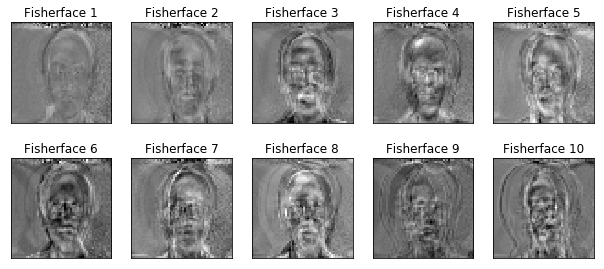

'for i in range(0,10):\n    fish_img=fisherfaces[i].reshape((55,55)).real\n    plt.subplot(4,5,1+i)\n    plt.imshow(fish_img,cmap=\'gray\')\n    plt.title("Fisherface "+str(i+1))\n    plt.subplots_adjust(right=1.1, top=1.4)\n    plt.tick_params(labelleft=\'off\', labelbottom=\'off\', bottom=\'off\',top=\'off\',right=\'off\',left=\'off\', which=\'both\')'

In [20]:
#Compute the inverse matrix and get its eigenvectors and eigenvalues
Sw_inverse=np.linalg.inv(Sw)
BinvA=np.matmul(Sw_inverse,Sb) 
inv_eigval, inv_eigvec=np.linalg.eig(BinvA) #The eigenvectors of this matrix will be used to obtain the fisherfaces
print(inv_eigvec.shape)
'''i_dx=np.argsort(-inv_eigval.real)
inv_eigval,inv_eigvec=inv_eigval[i_dx], inv_eigvec[:, i_dx]
inv_eigval=np.array(inv_eigval[0:14].real,dtype='float64',copy=True)
inv_eigvec=np.array(inv_eigvec[0:,0:14].real,dtype='float64',copy=True)'''
print("Length of eigenvectors of BinvA ",len(inv_eigvec))
print("Important principal components",len(imp_eig_vectors))
#Fisherfaces
inv_eigvec=np.transpose(inv_eigvec) #This will be project on fishers

#fisherfaces=np.dot(inv_eigvec,imp_eig_vectors) #Don't do this!
all_imgs_w = np.reshape(weights,(-1,inv_eigvec.shape[-1]))
iw = []
for i in range(len(all_imgs_w)):
    t = []
    for j in range(len(inv_eigvec)):
        t.append(np.dot(inv_eigvec[j],all_imgs_w[i]))
    iw.append(t)
iw = np.array(iw) #Some important shit
plt.figure(figsize=(12,6))
for i in range(1,11,1):
    plt.subplot(2,5,i)
    plt.imshow(np.reshape(np.real(np.matmul(inv_eigvec[i-1],imp_eig_vectors)),(55,55)),cmap='gray')
    plt.title('Fisherface {}'.format(i))
    plt.subplots_adjust(right=0.8, top=0.7)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

'''for i in range(0,10):
    fish_img=fisherfaces[i].reshape((55,55)).real
    plt.subplot(4,5,1+i)
    plt.imshow(fish_img,cmap='gray')
    plt.title("Fisherface "+str(i+1))
    plt.subplots_adjust(right=1.1, top=1.4)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')'''

## Get weights of training images using fisherfaces

In [15]:
#W_new represents the weights of each normalized training image using fisherfaces
w_new=np.array([np.dot(imp_eig_vectors,i) for i in normalized])
uk_wt_new=np.dot(fisherfaces,normalized_u_vector) #get weights of normalized vector
diff_new=w_new-uk_wt_new #find the difference
norms_new=np.linalg.norm(diff_new,axis=1) #calculate the norm for each training image for the given test image
index_new=np.argmin(norms_new) #find the index of the minimum norm (Distance)
print(index_new) 
plt.subplot(1,2,1)
plt.imshow(unknown_face_resize,cmap='gray')
plt.title('Unknown Image')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(imread('train/'+train_image_names[index_new]),(50,50)), cmap='gray')
plt.title('Recognized Person')

NameError: name 'fisherfaces' is not defined